In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
import glob
import os
import tensorboard as tb
import glob
import os
import pprint
import traceback
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import click
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from matplotlib.colors import ListedColormap

In [4]:
sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0,145,160],
    [0, 170, 230],
    [250,180,35],
    [0,70,125],
    [175, 25, 60],
    [170, 200 ,70],
    [250,115,80],
    [140, 90, 180],
      
])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

In [5]:
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    UNUSED_TAGS = ["on_train", "Cond. Acc"]
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            if any([(unused_tag in tag) for unused_tag in UNUSED_TAGS]):
                continue
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [6]:
paths = [
    "/gpfs/work/machnitz/plankton_logs/juwels_results", 
       ]

counter = 0

tf_files = []

for path in paths:
    for current_path, current_sub_dirs, current_files in os.walk(path):
        for file in current_files:
            if "events.out.tfevents" in file:
                tf_files.append(os.path.join(current_path, file))

In [7]:
df_raw = tflog2pandas(tf_files[1])

In [17]:
DEFAULT_SIZE_GUIDANCE = {
    "compressedHistograms": 1,
    "images": 0,
    "scalars": 0,  # 0 means load all
    "histograms": 1,
}
UNUSED_TAGS = ["on_train", "Cond. Acc"]
runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})

event_acc = EventAccumulator("/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/21-34-44/0/logs/tensorboard/default/all/events.out.tfevents.1642538567.jwb0058.juwels.29177.0", DEFAULT_SIZE_GUIDANCE)
event_acc.Reload()
tags = event_acc.Tags()["scalars"]
for tag in tags:
    if any([(unused_tag in tag) for unused_tag in UNUSED_TAGS]):
        continue
    event_list = event_acc.Scalars(tag)
    values = list(map(lambda x: x.value, event_list))
    step = list(map(lambda x: x.step, event_list))
    r = {"metric": [tag] * len(step), "value": values, "step": step}
    r = pd.DataFrame(r)
    runlog_data = pd.concat([runlog_data, r])

In [19]:
image_tags = event_acc.Tags()
image_tags

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['hp/loss', 'hp/accuracy', 'hp/epoch'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [10]:
images = event_acc.Images('Confusion_Matrix Training')

In [12]:
image = tf.io.decode_image(images[0].encoded_image_string)

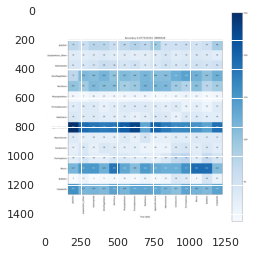

In [14]:
plt.imshow(image.numpy())

In [16]:
event_acc.Tags()

{'images': ['Confusion_Matrix Validation',
  'P(best guess | true) Validation',
  'Confusion_Matrix Training',
  'P(best guess | true) Training'],
 'audio': [],
 'histograms': [],
 'scalars': ['hp/loss',
  'hp/accuracy',
  'hp/epoch',
  'Cosine LR',
  'loss/Training',
  'Accuracy/Training',
  'epoch',
  'loss/Validation',
  'Accuracy/Validation',
  'Cond. Acc/Jellyfish Validation',
  'Cond. Acc/Zooplankton_Other Validation',
  'Cond. Acc/Gastropoda Validation',
  'Cond. Acc/Dinoflagellates Validation',
  'Cond. Acc/Noctiluca Validation',
  'Cond. Acc/Phytoplankton Validation',
  'Cond. Acc/Trichodesmium Validation',
  'Cond. Acc/Radiolaria Validation',
  'Cond. Acc/Appendicularia Validation',
  'Cond. Acc/MarineSnow Validation',
  'Cond. Acc/Ceratocoris Validation',
  'Cond. Acc/Trochophora Validation',
  'Cond. Acc/Blurry Validation',
  'Cond. Acc/Bubbles Validation',
  'Cond. Acc/Copepods Validation',
  'Cond. Acc/Jellyfish Training',
  'Cond. Acc/Zooplankton_Other Training',
  'Cond

In [9]:
import argparse
from pathlib import Path
from typing import Tuple

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

def init_torch(seed: int) -> None:
    """ Initialise torch with a seed """
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(240, 128)
        self.layer_2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        losses = [40, 20, 30, 10, 1, 0.9, 1, 1, 90, 100]
        loss = torch.tensor(float(losses[self.current_epoch])).to(batch[0].device)
        logs = {"val_loss": loss}
        self.log_dict(logs)


class LitDataset(Dataset):

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return torch.rand(10, 3, 8), torch.rand(10)

    def __len__(self) -> int:
        return 50000000


class LitDataModule(pl.LightningDataModule):

    def __init__(self, dataset: Dataset, batch_size: int):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)


def main() -> None:
    # Initialize pytorch
    init_torch(0)
    seed_everything(0)

    # Initialize data module
    dataset = LitDataset()
    dm = LitDataModule(dataset, 16)

    # Create experiment and fit
    outroot = Path(".")
    logger = TensorBoardLogger(save_dir=str(outroot / "logs"))
    trainer = Trainer(logger=logger,
                      gpus=1,
                      limit_train_batches=100,
                      limit_val_batches=100,
                      max_epochs=4
    )

    model = LitModel()
    trainer.fit(model, datamodule=dm)


main()

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: logs/default

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 30.8 K
1 | layer_2 | Linear | 1.3 K 
-----------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.129     Total estimated model params size (MB)


Global seed set to 0


Epoch 0:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 100/200 [00:00<00:00, 196.89it/s, loss=0.0893, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 100/200 [00:00<00:00, 313.89it/s, loss=0.0884, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 100/200 [00:00<00:00, 334.07it/s, loss=0.088, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████████████████████████████████████████████████████████████████████                                                                     | 100/200 [00:00<00:00, 339.47it/s, loss=0.0896, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████████████████